In [61]:
import numpy as np 
import pandas as pd 

# Input data files are available in the "../input/" directory. from Kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input/mitbih-database'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/mitbih-database/112annotations.txt
/kaggle/input/mitbih-database/233.csv
/kaggle/input/mitbih-database/108.csv
/kaggle/input/mitbih-database/118annotations.txt
/kaggle/input/mitbih-database/231.csv
/kaggle/input/mitbih-database/207.csv
/kaggle/input/mitbih-database/115annotations.txt
/kaggle/input/mitbih-database/108annotations.txt
/kaggle/input/mitbih-database/123annotations.txt
/kaggle/input/mitbih-database/102annotations.txt
/kaggle/input/mitbih-database/209.csv
/kaggle/input/mitbih-database/203annotations.txt
/kaggle/input/mitbih-database/202annotations.txt
/kaggle/input/mitbih-database/215annotations.txt
/kaggle/input/mitbih-database/232.csv
/kaggle/input/mitbih-database/223.csv
/kaggle/input/mitbih-database/114annotations.txt
/kaggle/input/mitbih-database/109annotations.txt
/kaggle/input/mitbih-database/217annotations.txt
/kaggle/input/mitbih-database/222annotations.txt
/kaggle/input/mitbih-database/119.csv
/kaggle/input/mitbih-database/234annotations.txt
/kaggle/in

In [62]:
import matplotlib.pyplot as plt
import csv
import pywt
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

import os

In [63]:
from keras.models import Sequential
from keras.layers import Convolution1D, Flatten, Dense, Dropout, Softmax,MaxPooling1D, AveragePooling1D
from keras.optimizers import Adam 
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import regularizers
from tensorflow.keras.layers import BatchNormalization

## Approach:

1. Initially data processing was done by denoising the data and then it was normalised using z score values
2. Now what the approach was to classify from the dataset which places do I get abnormal labels I was taking values which were in the range of +180 and -180 so in this range my abnormal point lies at 0
3. As we had 2 files where 1 was CSV and the other was txt so we had to combine the data together, so while creating my X_train etc. I'd combined those based 
4. So my train set contains of values which are at the point 0 in our range or window of -180 to 180 and the target variables are the values from N,A,R,V,L

In [64]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [65]:
plt.rcParams["figure.figsize"] = (10,6)

In [66]:
classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes
count_classes

[0, 0, 0, 0, 0]

In [67]:
path = '/kaggle/input/mitbih-database'
filenames = next(os.walk(path))[2]
records=list()
annotations=list()
filenames.sort()

In [68]:
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    if(file_extension=='.csv'):
        records.append(path+'/'+filename+file_extension)
    else:
        annotations.append(path+'/'+filename+file_extension)

records[0]

'/kaggle/input/mitbih-database/100.csv'

In [69]:
records[1]

'/kaggle/input/mitbih-database/101.csv'

In [70]:
temp_signal=[]
with open(records[6],'r') as csvfile:
    filereader = csv.reader(csvfile,delimiter=',',quotechar='|')
    row_index = -1
    for row in filereader:
        if(row_index >= 0):
            temp_signal.insert(row_index, int(row[1]))
        row_index += 1

In [71]:
temp_signal[:10]

[962, 962, 962, 962, 962, 962, 962, 962, 966, 967]

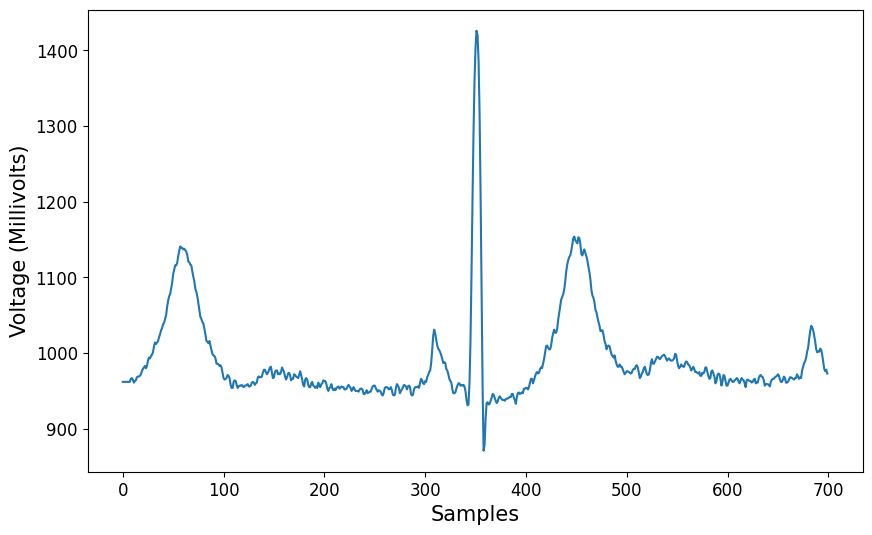

In [72]:
plt.plot(temp_signal[:700])
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage (Millivolts)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('before_preprocessing')

In [73]:
temp2signal=temp_signal

In [74]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
  #  print(len(coeffs))
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    return datarec

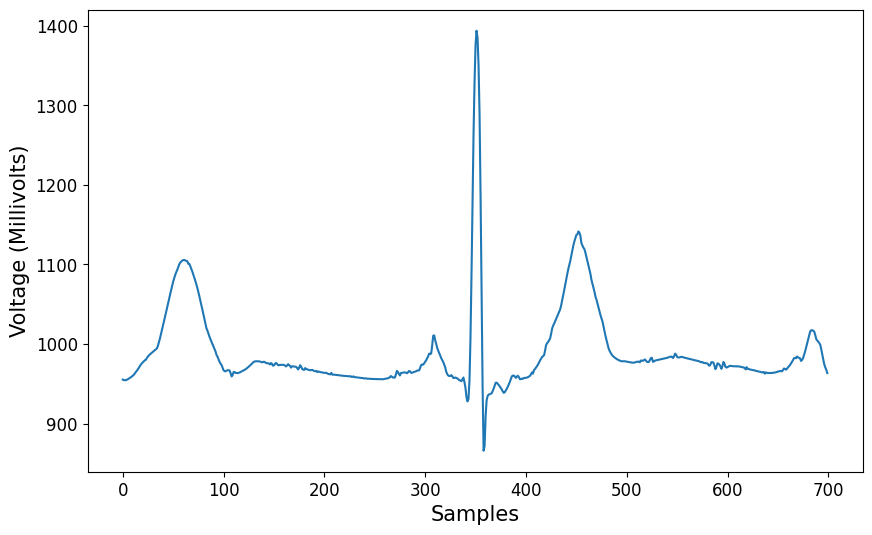

In [75]:
temp_signal=denoise(temp_signal)
plt.plot(temp_signal[:700])
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage (Millivolts)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('after_denoising')

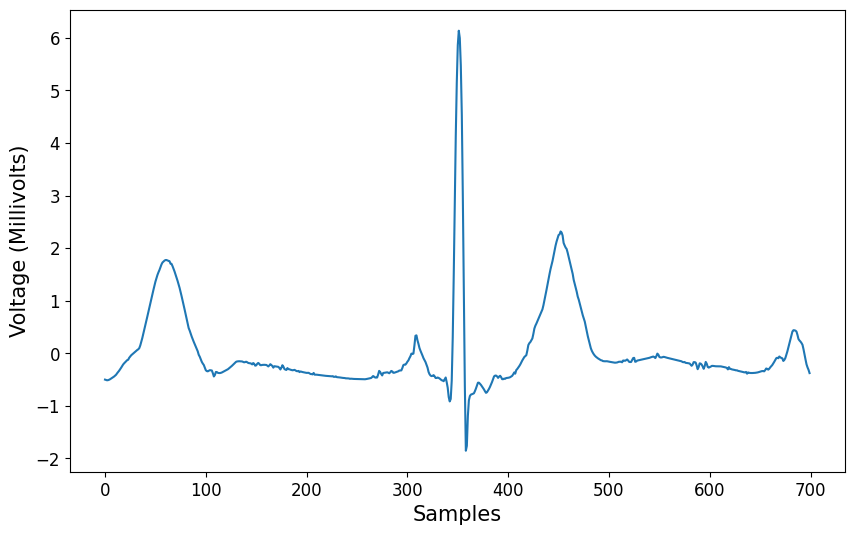

In [76]:
temp_signal = stats.zscore(temp_signal)
plt.plot(temp_signal[:700])
plt.xlabel('Samples', fontsize=15)
plt.ylabel('Voltage (Millivolts)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('after_norm')

# Preprocessing: Denoising, Scaling, Classes Segmentation


In [77]:
X=list()
y=list()
window_size=180
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'r') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') 
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1

        
    signals = denoise(signals)
    #signals = signals.reshape(-1,1)
    signals = stats.zscore(signals)

    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): 
            splitted = data[d].split(' ') 
            splitted = filter(None, splitted)
            next(splitted) 
            pos = int(next(splitted)) 
            arrhythmia_type = next(splitted) 
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]   

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

(100012, 360) (100012,)


In [78]:
count_classes

[75052, 8075, 7259, 2546, 7130]

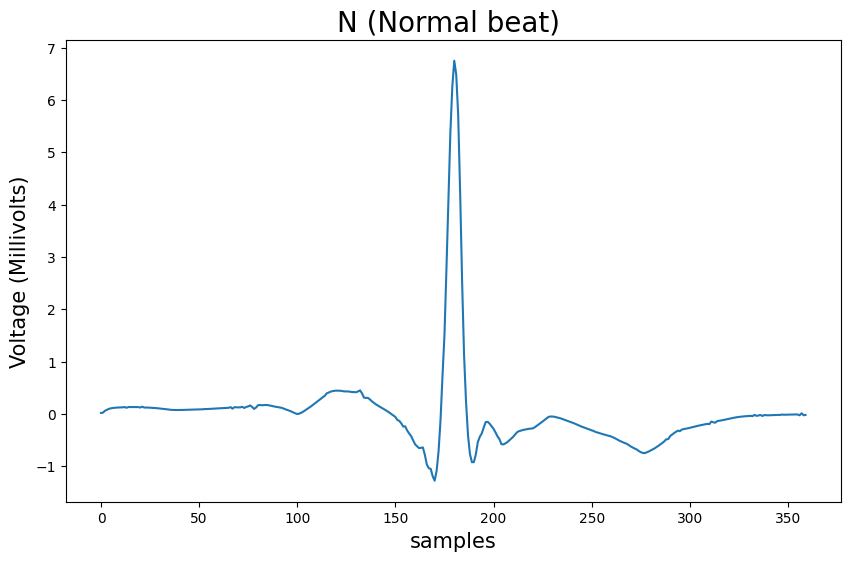

In [79]:
i=0;
while y[i]!=0:
    i=i+1

plt.plot(X[i])
plt.title('N (Normal beat) ', fontsize=20)
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.savefig('N')

0
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


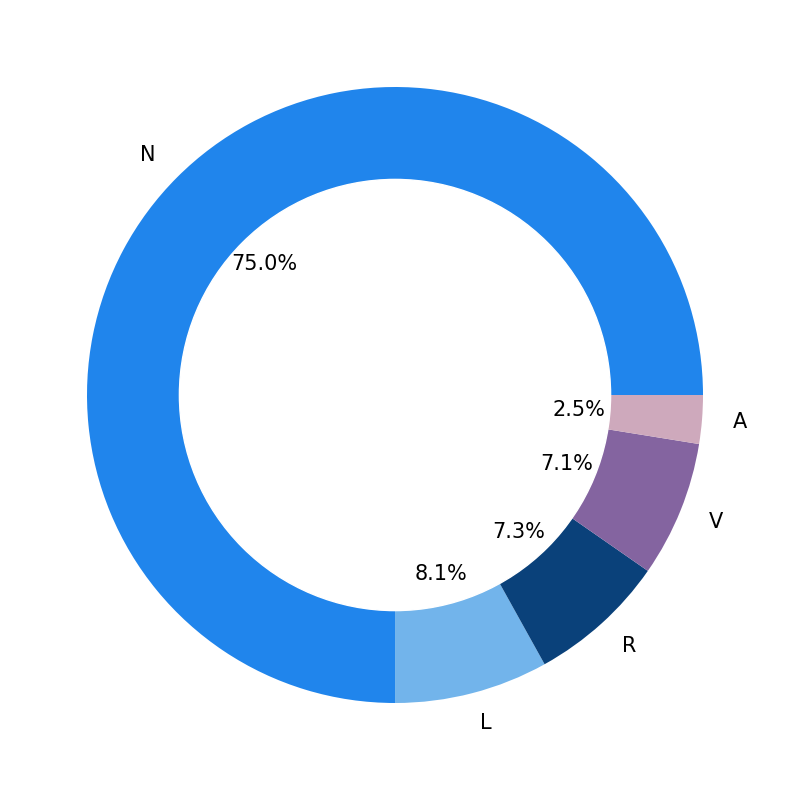

In [80]:
y_df = pd.DataFrame(y)
y_df.head()
per_class = y_df[y_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%', textprops={'fontsize':15})
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
p.savefig('Before_piechart')

0
0    75011
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


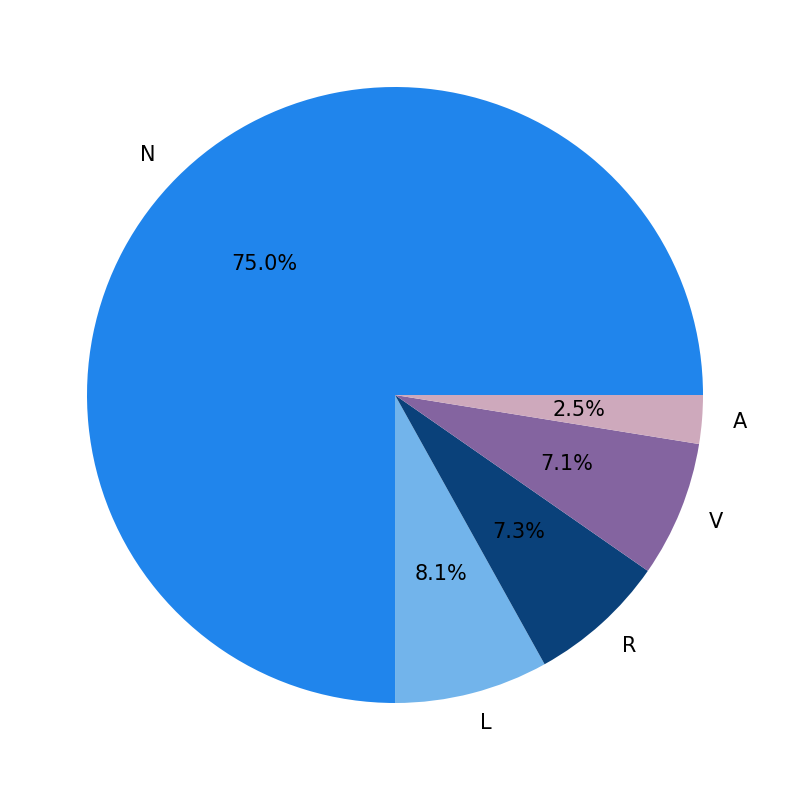

<Figure size 1000x600 with 0 Axes>

In [81]:
y_df = pd.DataFrame(y)
y_df.head()
per_class = y_df[y_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%', textprops={'fontsize':15})
plt.show()
plt.savefig('Before_piechart')

In [82]:
X = np.array(X)
X_reshaped = X.reshape(-1,360,)
X_reshaped.shape

(100012, 360)

In [83]:
X_df = pd.DataFrame(X_reshaped)
X_df.head()

,0,1,2,3,4,5,6,7,8,9,...,350,351,352,353,354,355,356,357,358,359
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.014193,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140757,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,-0.005353,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.014056,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.024847,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073


In [84]:
X_new_df = pd.concat([X_df,y_df],axis=1)
X_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,351,352,353,354,355,356,357,358,359,0
0,0.018228,0.022953,0.058424,0.077107,0.095080,0.105492,0.112325,0.116982,0.119703,0.122254,...,-0.013640,-0.013518,-0.012969,-0.010249,-0.013186,-0.027581,0.010994,-0.026885,-0.020095,0
1,-0.366827,-0.344524,-0.320039,-0.330324,-0.299629,-0.292238,-0.283900,-0.275759,-0.267345,-0.257942,...,-0.140611,-0.140669,-0.140735,-0.141352,-0.140082,-0.136719,-0.144822,-0.139946,-0.142478,0
2,-0.171359,-0.140344,-0.109854,-0.078079,-0.048978,-0.034990,-0.028194,-0.024550,-0.024222,-0.023859,...,0.001325,0.007875,0.015828,0.025088,0.030657,0.026670,0.056487,0.028112,0.028259,0
3,-0.186526,-0.182575,-0.177326,-0.171800,-0.165320,-0.158725,-0.151677,-0.144942,-0.140875,-0.138009,...,0.021386,0.032036,0.043188,0.058269,0.074966,0.076706,0.073569,0.093104,0.116388,0
4,-0.369240,-0.368380,-0.344557,-0.314211,-0.295571,-0.279271,-0.261415,-0.243202,-0.221928,-0.200658,...,-0.019342,-0.014265,-0.009238,-0.004046,0.001153,0.006449,0.011785,0.016524,0.021073,0


In [85]:
ax=list(range(361))
X_new_df = X_new_df.set_axis(ax, axis='columns')

In [86]:
df_0=(X_new_df[X_new_df[X_new_df.shape[1]-1]==0]).sample(n=20000,random_state=42)
df_1=X_new_df[X_new_df[X_new_df.shape[1]-1]==1]
df_2=X_new_df[X_new_df[X_new_df.shape[1]-1]==2]
df_3=X_new_df[X_new_df[X_new_df.shape[1]-1]==3]
df_4=X_new_df[X_new_df[X_new_df.shape[1]-1]==4]

df_1_upsample=resample(df_1,replace=True,n_samples=7000,random_state=125)
df_2_upsample=resample(df_2,replace=True,n_samples=7000,random_state=77)
df_3_upsample=resample(df_3,replace=True,n_samples=7000,random_state=103)
df_4_upsample=resample(df_4,replace=True,n_samples=7000,random_state=59)

X_new_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])


360
0    20000
1     7000
2     7000
3     7000
4     7000
Name: count, dtype: int64


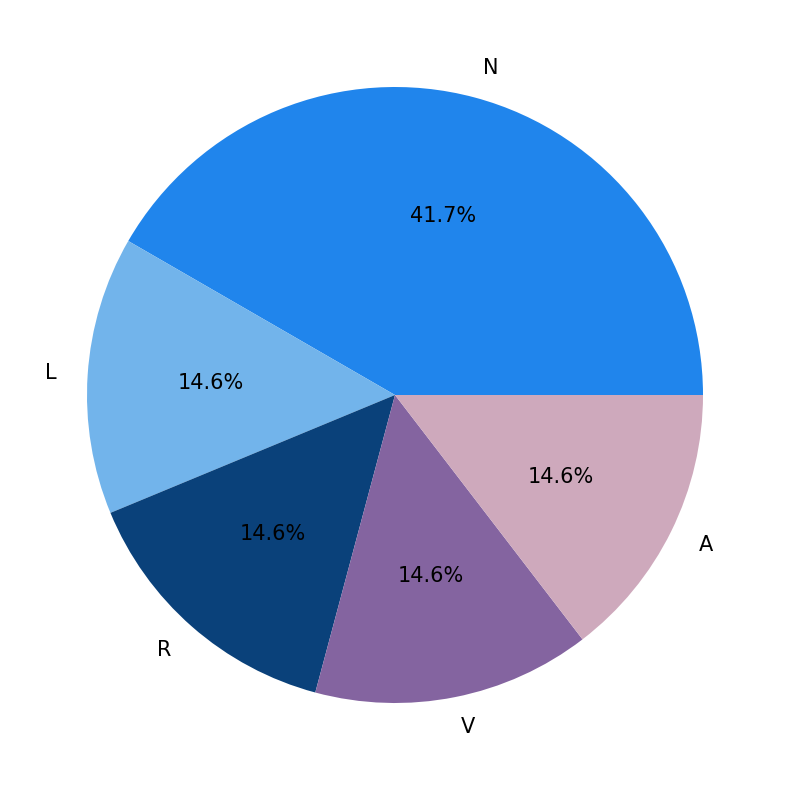

<Figure size 1000x600 with 0 Axes>

In [87]:
per_class = X_new_df[X_new_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(30,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['#2085ec','#72b4eb','#0a417a','#8464a0','#cea9bc'],autopct='%1.1f%%',textprops={'fontsize':15})
plt.show()
plt.savefig('after_piechart')

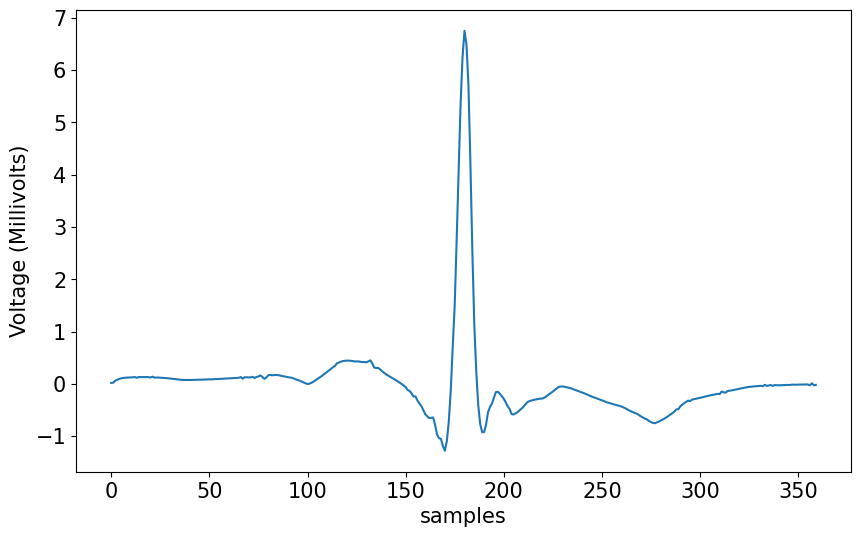

In [88]:
i=0;
while y[i]!=0:
    i=i+1

plt.plot(X[i])
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('N')

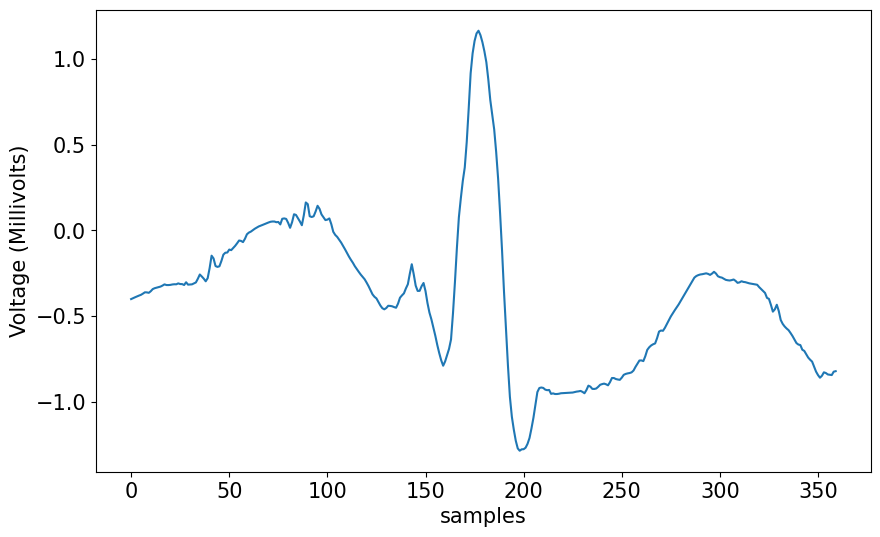

In [89]:
i=0;
while y[i]!=1:
    i=i+1

plt.plot(X[i])
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('L')

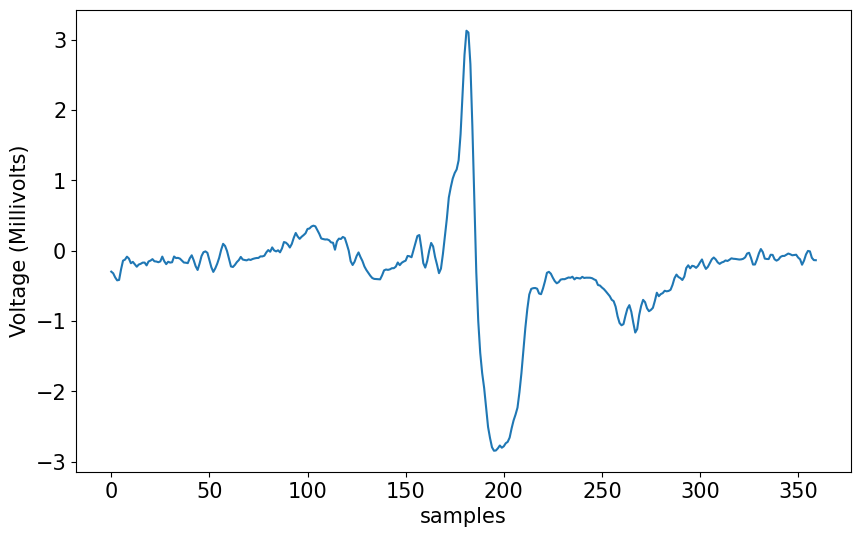

In [90]:
i=0;
while y[i]!=2:
    i=i+1

plt.plot(X[i]) 
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('R')

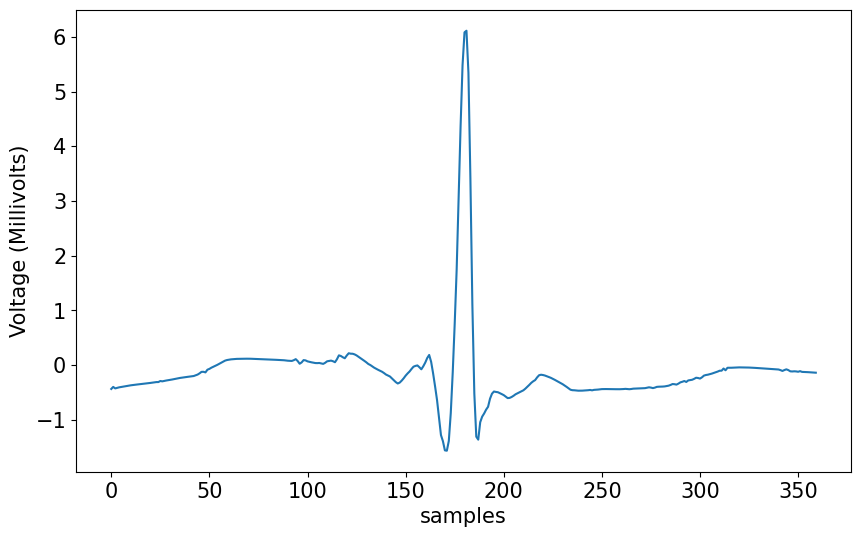

In [91]:
i=0;
while y[i]!=3:
    i=i+1

plt.plot(X[i])
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('A')

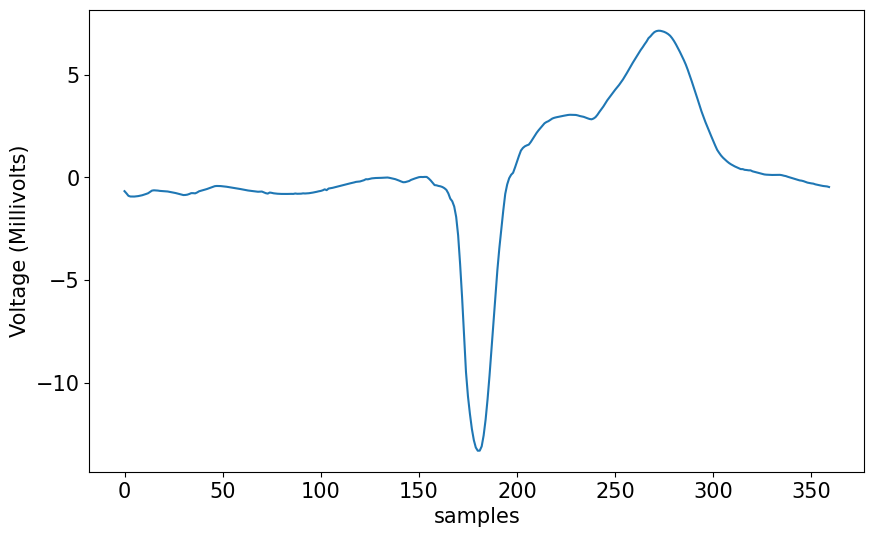

In [92]:
i=0;
while y[i]!=4:
    i=i+1

plt.plot(X[i])
plt.xlabel('samples',fontsize=15);
plt.ylabel('Voltage (Millivolts)',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('V')

In [93]:
train, test = train_test_split(X_new_df, test_size=0.20, random_state=7)

print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (38400, 361)
X_test  :  (9600, 361)


In [94]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
print(np.shape(y_train), np.shape(y_test))

(38400, 5) (9600, 5)


In [95]:
X_train = train.iloc[:,:train.shape[1]-1].values
X_test = test.iloc[:,:test.shape[1]-1].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)
print(np.shape(X_train), np.shape(X_test))

(38400, 360, 1) (9600, 360, 1)


In [96]:
X_train

array([[[ 3.34189619],
        [ 3.25219265],
        [ 2.87078817],
        ...,
        [ 2.14705119],
        [ 2.91551618],
        [ 3.66491624]],

       [[ 0.13732814],
        [ 0.10163867],
        [ 0.17278825],
        ...,
        [-0.43695935],
        [-0.39387193],
        [-0.40884471]],

       [[ 0.03387686],
        [ 0.03203674],
        [ 0.07088467],
        ...,
        [ 0.24033802],
        [ 0.25007395],
        [ 0.26432983]],

       ...,

       [[-0.59741731],
        [-0.55982779],
        [-0.5129274 ],
        ...,
        [-0.46687549],
        [-0.46997383],
        [-0.48170831]],

       [[ 4.75083938],
        [ 5.0833885 ],
        [ 5.34792497],
        ...,
        [ 0.10125372],
        [ 0.10584571],
        [ 0.11049497]],

       [[ 0.08081461],
        [ 0.10717277],
        [ 0.13168527],
        ...,
        [-0.04403662],
        [-0.06507996],
        [-0.09084247]]])

My own Architecture from the paper: **Atrial Fibrillation Detection and ECG Classification based on
Convolutional Recurrent Neural Network**



In [97]:
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Dropout, Concatenate, Masking, LSTM, Dense, Softmax
from tensorflow.keras.models import Model


In [40]:
'''
Defining the model architecture as provided in the paper
'''



input_shape = (360, 1)  # Assuming window_size * 2 = 360, with 1 channel

# ECG Input
ecg_input = Input(shape=input_shape, name='ecg_input')
x1 = Conv1D(filters=32, kernel_size=5, activation='relu')(ecg_input)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = Dropout(0.5)(x1)
x1 = Conv1D(filters=64, kernel_size=5, activation='relu')(x1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = Dropout(0.5)(x1)

concatenated = x1

masked = Masking(mask_value=0.0)(concatenated)

x = LSTM(100, return_sequences=True)(masked)
x = LSTM(100)(x)

output = Dense(5, activation='softmax')(x)

model = Model(inputs=ecg_input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ecg_input (InputLayer)      [(None, 360, 1)]          0         
                                                                 
 conv1d_2 (Conv1D)           (None, 356, 32)           192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 178, 32)          0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 178, 32)           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 174, 64)           10304     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 87, 64)           0         
 1D)                                                         

In [41]:
# Model Training
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Model Evaluation
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')

Epoch 1/20
960/960 [==============================] - 25s 15ms/step - loss: 0.6997 - accuracy: 0.7532 - val_loss: 0.4019 - val_accuracy: 0.8643
Epoch 2/20
960/960 [==============================] - 13s 13ms/step - loss: 0.3203 - accuracy: 0.8939 - val_loss: 0.2393 - val_accuracy: 0.9273
Epoch 3/20
960/960 [==============================] - 13s 14ms/step - loss: 0.2405 - accuracy: 0.9206 - val_loss: 0.2263 - val_accuracy: 0.9284
Epoch 4/20
960/960 [==============================] - 13s 14ms/step - loss: 0.2093 - accuracy: 0.9317 - val_loss: 0.1793 - val_accuracy: 0.9453
Epoch 5/20
960/960 [==============================] - 12s 13ms/step - loss: 0.1723 - accuracy: 0.9441 - val_loss: 0.1513 - val_accuracy: 0.9514
Epoch 6/20
960/960 [==============================] - 12s 13ms/step - loss: 0.1523 - accuracy: 0.9514 - val_loss: 0.1269 - val_accuracy: 0.9587
Epoch 7/20
960/960 [==============================] - 13s 13ms/step - loss: 0.1399 - accuracy: 0.9537 - val_loss: 0.1263 - val_accuracy:

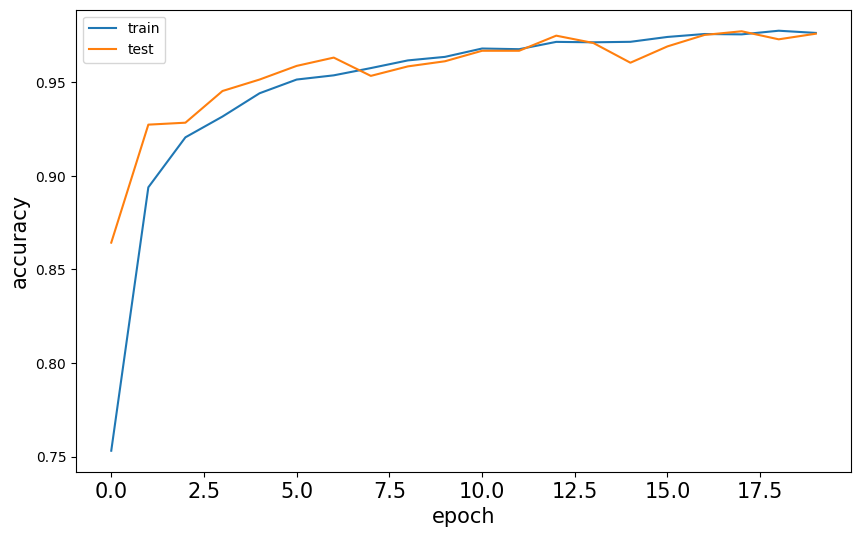

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy',fontsize=20)
plt.xticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylabel('accuracy',fontsize=15)
plt.xlabel('epoch',fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('accuracy_plot')
plt.show()


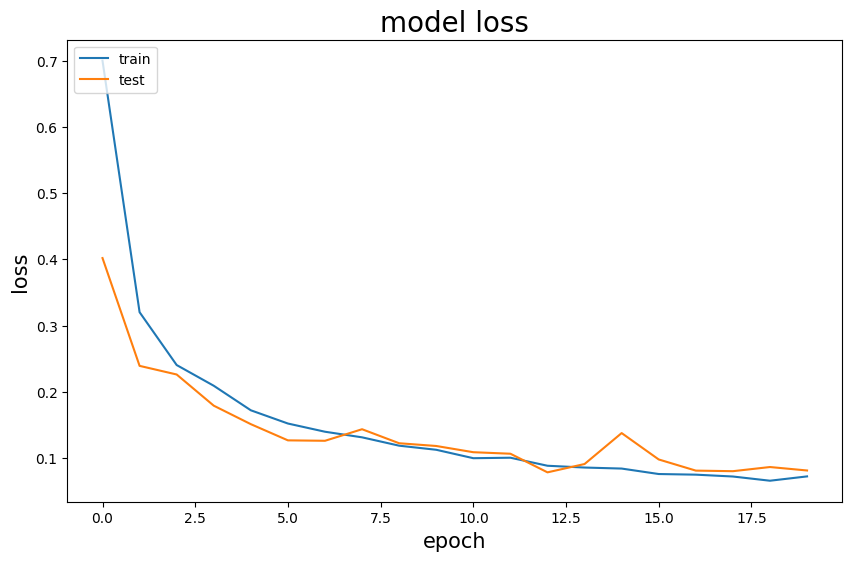

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=20)
plt.ylabel('loss', fontsize=15)
plt.xlabel('epoch', fontsize=15)
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('loss_plot')
plt.show()


In [44]:
score = model.evaluate(X_test, y_test)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

300/300 [==============================] - 2s 6ms/step - loss: 0.0864 - accuracy: 0.9721
Test Loss: 0.08638731390237808
Test accuracy: 0.972083330154419


300/300 [==============================] - 4s 5ms/step


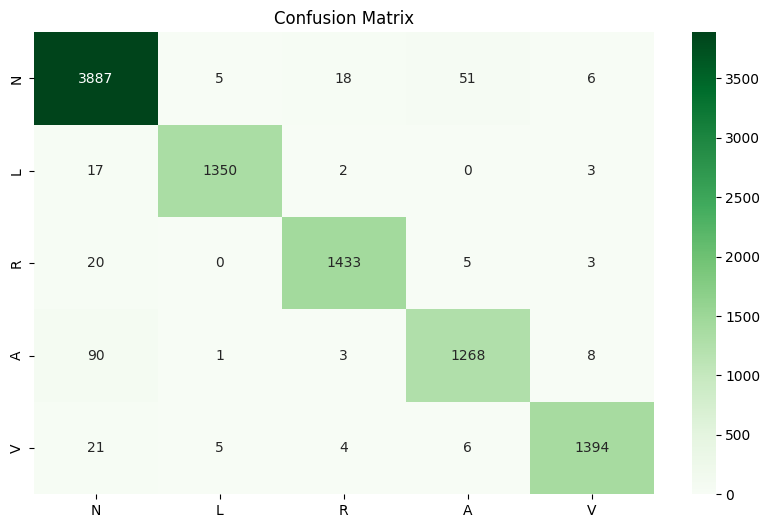

In [45]:
y_true=[]
for element in y_test:
    y_true.append(np.argmax(element))
prediction_proba=model.predict(X_test)
prediction=np.argmax(prediction_proba,axis=1)
ax=plt.subplot()
custCnnConfMat = confusion_matrix(y_true, prediction)
sns.heatmap(custCnnConfMat, annot=True,fmt='d', cmap='Greens',ax=ax)
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.savefig('cm')

In [46]:
from sklearn.metrics import classification_report

cf = classification_report(y_true, prediction, target_names=classes,digits=4)
print(cf)

              precision    recall  f1-score   support

           N     0.9633    0.9798    0.9715      3967
           L     0.9919    0.9840    0.9879      1372
           R     0.9815    0.9808    0.9812      1461
           A     0.9534    0.9255    0.9393      1370
           V     0.9859    0.9748    0.9803      1430

    accuracy                         0.9721      9600
   macro avg     0.9752    0.9690    0.9720      9600
weighted avg     0.9721    0.9721    0.9720      9600



**Hyper Parameter Optimization** - Using Gaussian Processes

In [35]:
!pip install scikit-optimize

In [104]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from skopt import gp_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.utils import use_named_args

In [100]:

# Define the hyperparameter space
dim_learning_rate = Real(low=1e-6, high=1e-2, prior='log-uniform', name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=5, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid'], name='activation')
dim_num_filters = Integer(low=16, high=64, name='num_filters')
dim_kernel_size = Integer(low=3, high=7, name='kernel_size')
dim_dropout_rate = Real(low=0.2, high=0.5, name='dropout_rate')
dim_lstm_units = Integer(low=50, high=200, name='lstm_units')

# The hyperparameter space grid
param_grid = [
    dim_learning_rate,
    dim_num_dense_layers,
    dim_num_dense_nodes,
    dim_activation,
    dim_num_filters,
    dim_kernel_size,
    dim_dropout_rate,
    dim_lstm_units
]

In [119]:
default_parameters = [
    1e-5,   # learning_rate
    2,      # num_dense_layers
    128,    # num_dense_nodes
    'relu', # activation
    32,     # num_filters
   (5),      # kernel_size
    0.3,    # dropout_rate
    100     # lstm_units
]

# objective(x=default_parameters)

In [101]:
# we will save the model with this name
path_best_model = 'crnn_model.h5'

# starting point for the optimization
best_accuracy = 0

In [111]:
def create_crnn(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    num_filters,
    kernel_size,
    dropout_rate,
    lstm_units
):
    model = Sequential()
    
    # Convolutional layers for ECG input.
    model.add(Conv1D(filters=num_filters, kernel_size=(kernel_size,), activation=activation, padding='same', input_shape=(360, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=dropout_rate))
    model.add(Conv1D(filters=num_filters * 2, kernel_size=(kernel_size,), activation=activation, padding='same'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(rate=dropout_rate))

    # LSTM layer
    model.add(LSTM(units=lstm_units, return_sequences=True))
    model.add(LSTM(units=lstm_units, return_sequences=False))
    
    # Add fully-connected Dense layers.
    for i in range(num_dense_layers):
        model.add(Dense(num_dense_nodes, activation=activation))
        model.add(Dropout(rate=dropout_rate))

    # Output layer with softmax activation
    model.add(Dense(5, activation='softmax'))

    # Compile model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [116]:
@use_named_args(param_grid)
def objective(
    learning_rate,
    num_dense_layers,
    num_dense_nodes,
    activation,
    num_filters,
    kernel_size,
    dropout_rate,
    lstm_units,
):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    num_filters:       Number of filters in Conv1D layer.
    kernel_size:       Kernel size for Conv1D layer.
    dropout_rate:      Dropout rate for Dropout layers.
    lstm_units:        Number of units in LSTM layer.
    """
    
    # Print the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('num_dense_layers:', num_dense_layers)
    print('num_dense_nodes:', num_dense_nodes)
    print('activation:', activation)
    print('num_filters:', num_filters)
    print('kernel_size:', kernel_size)
    print('dropout_rate:', dropout_rate)
    print('lstm_units:', lstm_units)
    print()
    
    # Create the neural network with the hyper-parameters.
    model = create_crnn(
        learning_rate=learning_rate,
        num_dense_layers=num_dense_layers,
        num_dense_nodes=num_dense_nodes,
        activation=activation,
        num_filters=num_filters,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
        lstm_units=lstm_units
    )

    # Set a learning rate annealer
    learning_rate_reduction = ReduceLROnPlateau(
        monitor='val_accuracy', 
        patience=2, 
        verbose=1, 
        factor=0.5, 
        min_lr=0.00001
    )
    
    # Train the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_split=0.1,
        callbacks=[learning_rate_reduction]
    )

    # Get the classification accuracy on the validation set after the last epoch
    accuracy = history.history['val_accuracy'][-1]

    # Print the classification accuracy
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    global best_accuracy

    if accuracy > best_accuracy:
        model.save(path_best_model)
        best_accuracy = accuracy

    del model
    
    return -accuracy

In [118]:
gp_ = gp_minimize(
    objective,  # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0
)

learning rate: 1.0e-05
num_dense_layers: 2
num_dense_nodes: 128
activation: relu
num_filters: 32
kernel_size: 5
dropout_rate: 0.3
lstm_units: 100

Epoch 1/20
270/270 [==============================] - 7s 18ms/step - loss: 1.5796 - accuracy: 0.4069 - val_loss: 1.5544 - val_accuracy: 0.4133 - lr: 1.0000e-05
Epoch 2/20
270/270 [==============================] - 4s 15ms/step - loss: 1.5340 - accuracy: 0.4180 - val_loss: 1.5178 - val_accuracy: 0.4133 - lr: 1.0000e-05
Epoch 3/20
270/270 [==============================] - 4s 15ms/step - loss: 1.5048 - accuracy: 0.4179 - val_loss: 1.4776 - val_accuracy: 0.4133 - lr: 1.0000e-05
Epoch 4/20
270/270 [==============================] - 4s 15ms/step - loss: 1.4072 - accuracy: 0.4379 - val_loss: 1.3681 - val_accuracy: 0.4768 - lr: 1.0000e-05
Epoch 5/20
270/270 [==============================] - 4s 15ms/step - loss: 1.2800 - accuracy: 0.5077 - val_loss: 1.2532 - val_accuracy: 0.5260 - lr: 1.0000e-05
Epoch 6/20
270/270 [==============================] -

In [120]:
# gp_minimize performs by default GP Optimization 
# using a Marten Kernel

gp_ = gp_minimize(
    objective, # the objective function to minimize
    param_grid, # the hyperparameter space
    x0=default_parameters, # the initial parameters to test
    acq_func='EI', # the acquisition function
    n_calls=30, # the number of subsequent evaluations of f(x)
    random_state=0, 
)

learning rate: 1.0e-05
num_dense_layers: 2
num_dense_nodes: 128
activation: relu
num_filters: 32
kernel_size: 5
dropout_rate: 0.3
lstm_units: 100

Epoch 1/20
270/270 [==============================] - 7s 18ms/step - loss: 1.5922 - accuracy: 0.3646 - val_loss: 1.5700 - val_accuracy: 0.4133 - lr: 1.0000e-05
Epoch 2/20
270/270 [==============================] - 4s 15ms/step - loss: 1.5365 - accuracy: 0.4177 - val_loss: 1.5117 - val_accuracy: 0.4133 - lr: 1.0000e-05
Epoch 3/20
270/270 [==============================] - 4s 15ms/step - loss: 1.4715 - accuracy: 0.4214 - val_loss: 1.4148 - val_accuracy: 0.4393 - lr: 1.0000e-05
Epoch 4/20
270/270 [==============================] - 4s 15ms/step - loss: 1.3456 - accuracy: 0.4894 - val_loss: 1.3562 - val_accuracy: 0.4992 - lr: 1.0000e-05
Epoch 5/20
270/270 [==============================] - 4s 15ms/step - loss: 1.2733 - accuracy: 0.5159 - val_loss: 1.2982 - val_accuracy: 0.5052 - lr: 1.0000e-05
Epoch 6/20
270/270 [==============================] -

In [121]:
# function value at the minimum.
# note that it is the negative of the accuracy

"Best score=%.4f" % gp_.fun

'Best score=-0.9872'

In [122]:
gp_.x

[0.01, 1, 363, 'relu', 16, 7, 0.2, 50]

In [123]:
gp_.space

Space([Real(low=1e-06, high=0.01, prior='log-uniform', transform='normalize'),
       Integer(low=1, high=5, prior='uniform', transform='normalize'),
       Integer(low=5, high=512, prior='uniform', transform='normalize'),
       Categorical(categories=('relu', 'sigmoid'), prior=None),
       Integer(low=16, high=64, prior='uniform', transform='normalize'),
       Integer(low=3, high=7, prior='uniform', transform='normalize'),
       Real(low=0.2, high=0.5, prior='uniform', transform='normalize'),
       Integer(low=50, high=200, prior='uniform', transform='normalize')])

In [ ]:
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations

<Axes: title={'center': 'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

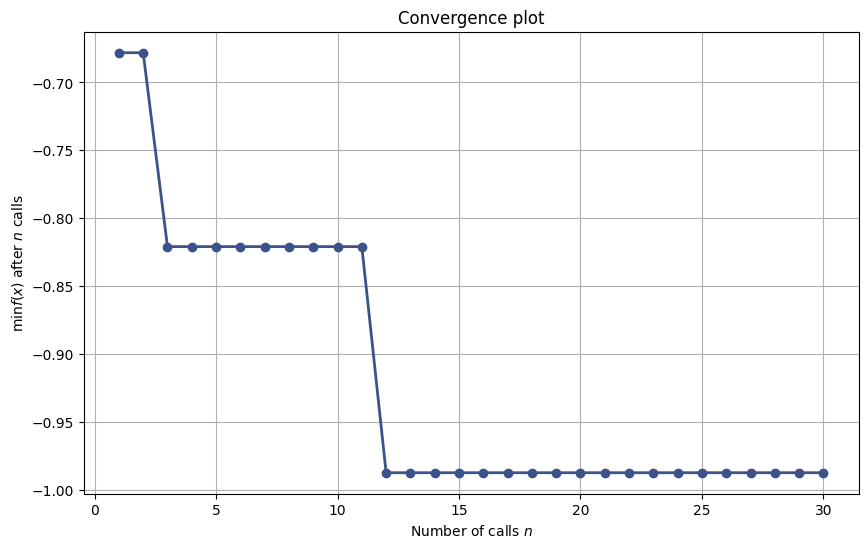

In [127]:
plot_convergence(gp_)

In [130]:
dim_names=[
    'learning_rate',
    'num_dense_layers',
    'num_dense_nodes',
    'activation',
    'num_filters',
    'kernel_size',
    'dropout_rate',
    'lstm_units'
]

Underlying plots show that how each parameter was tested out and the more the change in it's graph means the more that parameter was tweaked and then found the best results. 

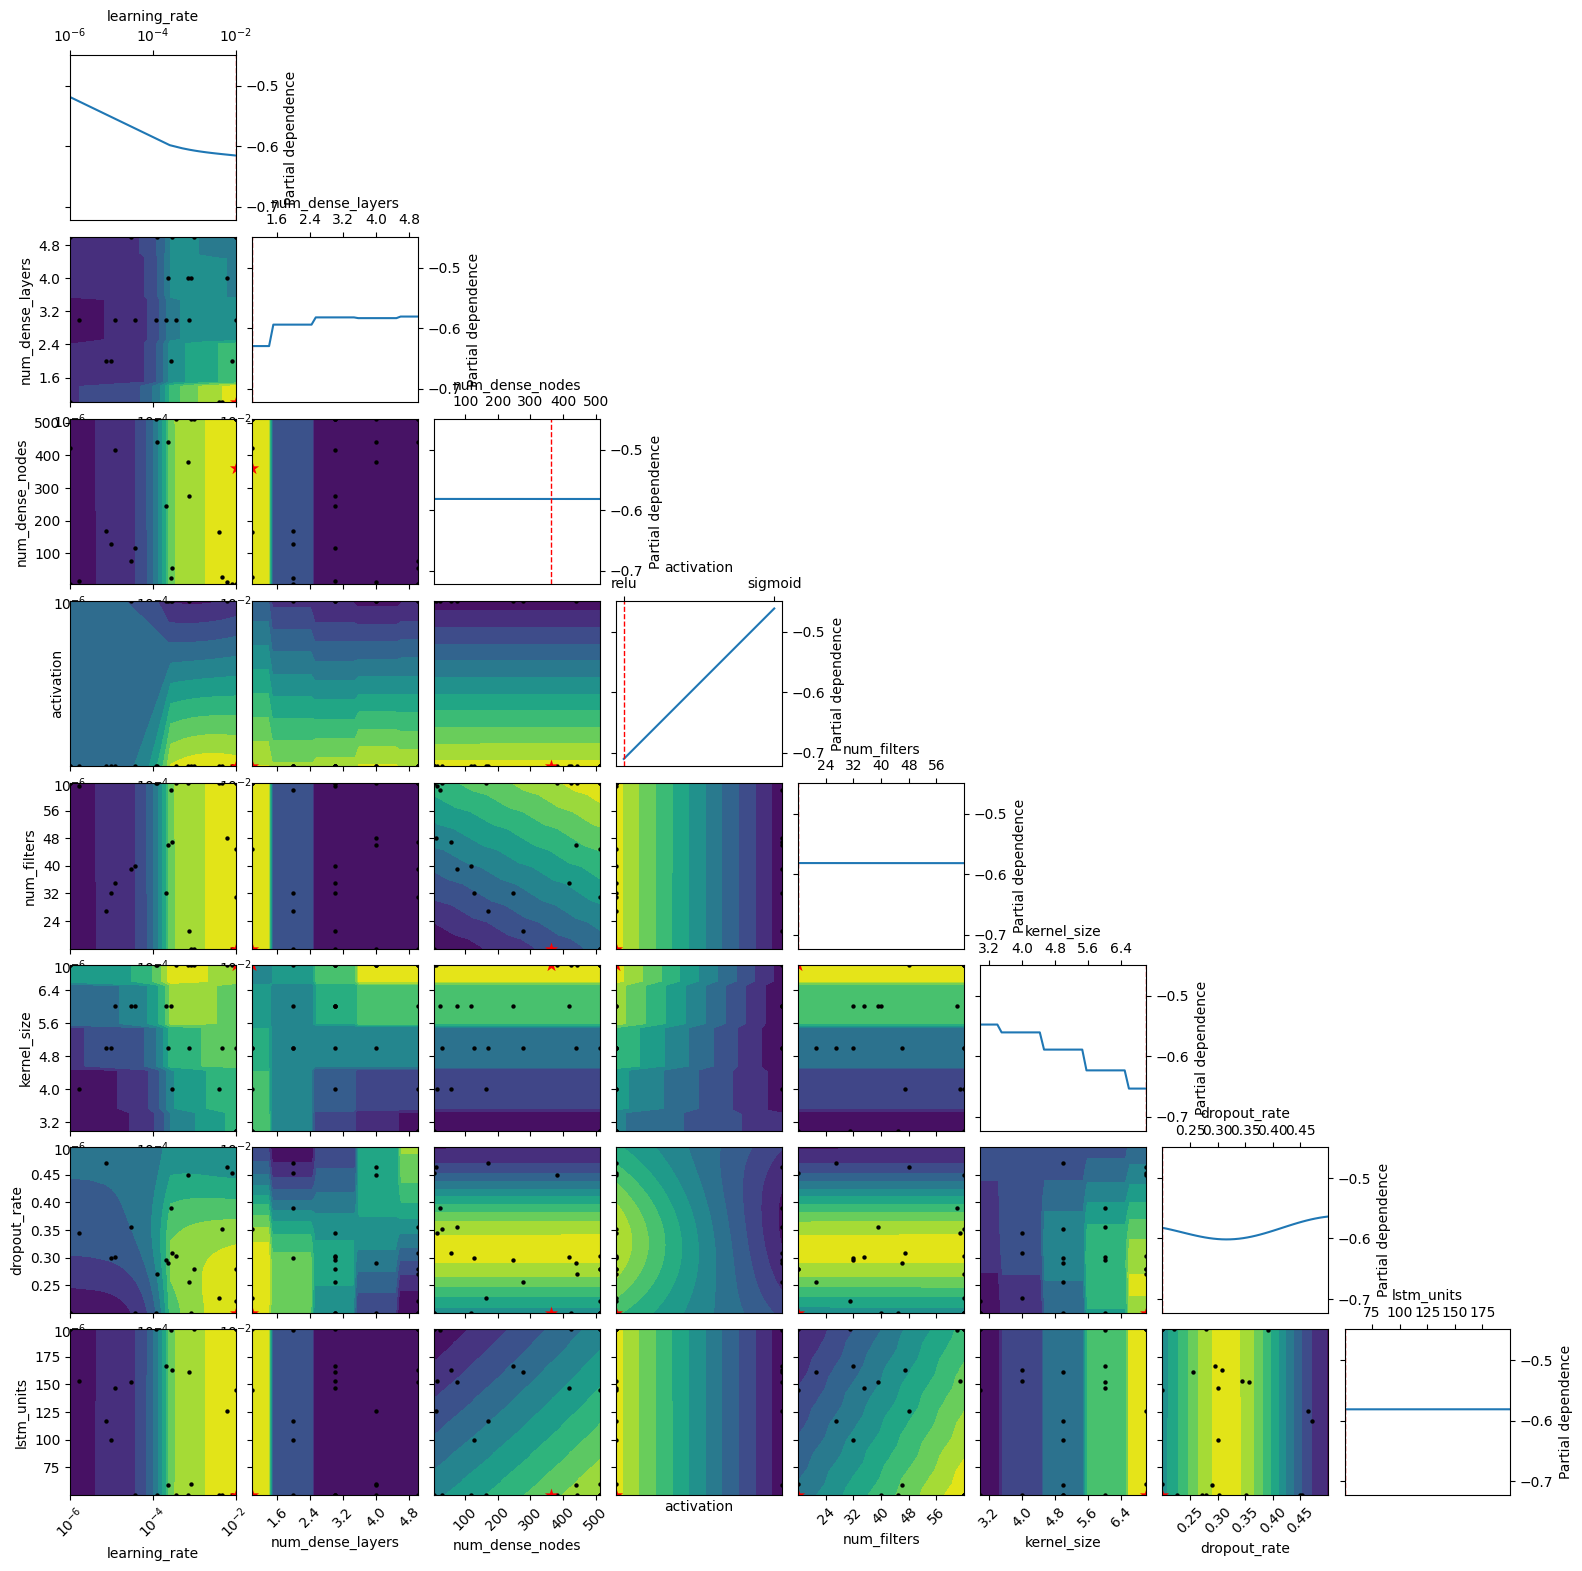

In [131]:
'''A straight or nearly dtraight line means changing that parameter didn't affect at all on the accuracy of the models.
The cross mark indicated the best value for that parameter. While the density plots show that the places where there are lighter shades means the parameter was minimized the most in that region
'''
plot_objective(result=gp_, plot_dims=dim_names)
plt.show()

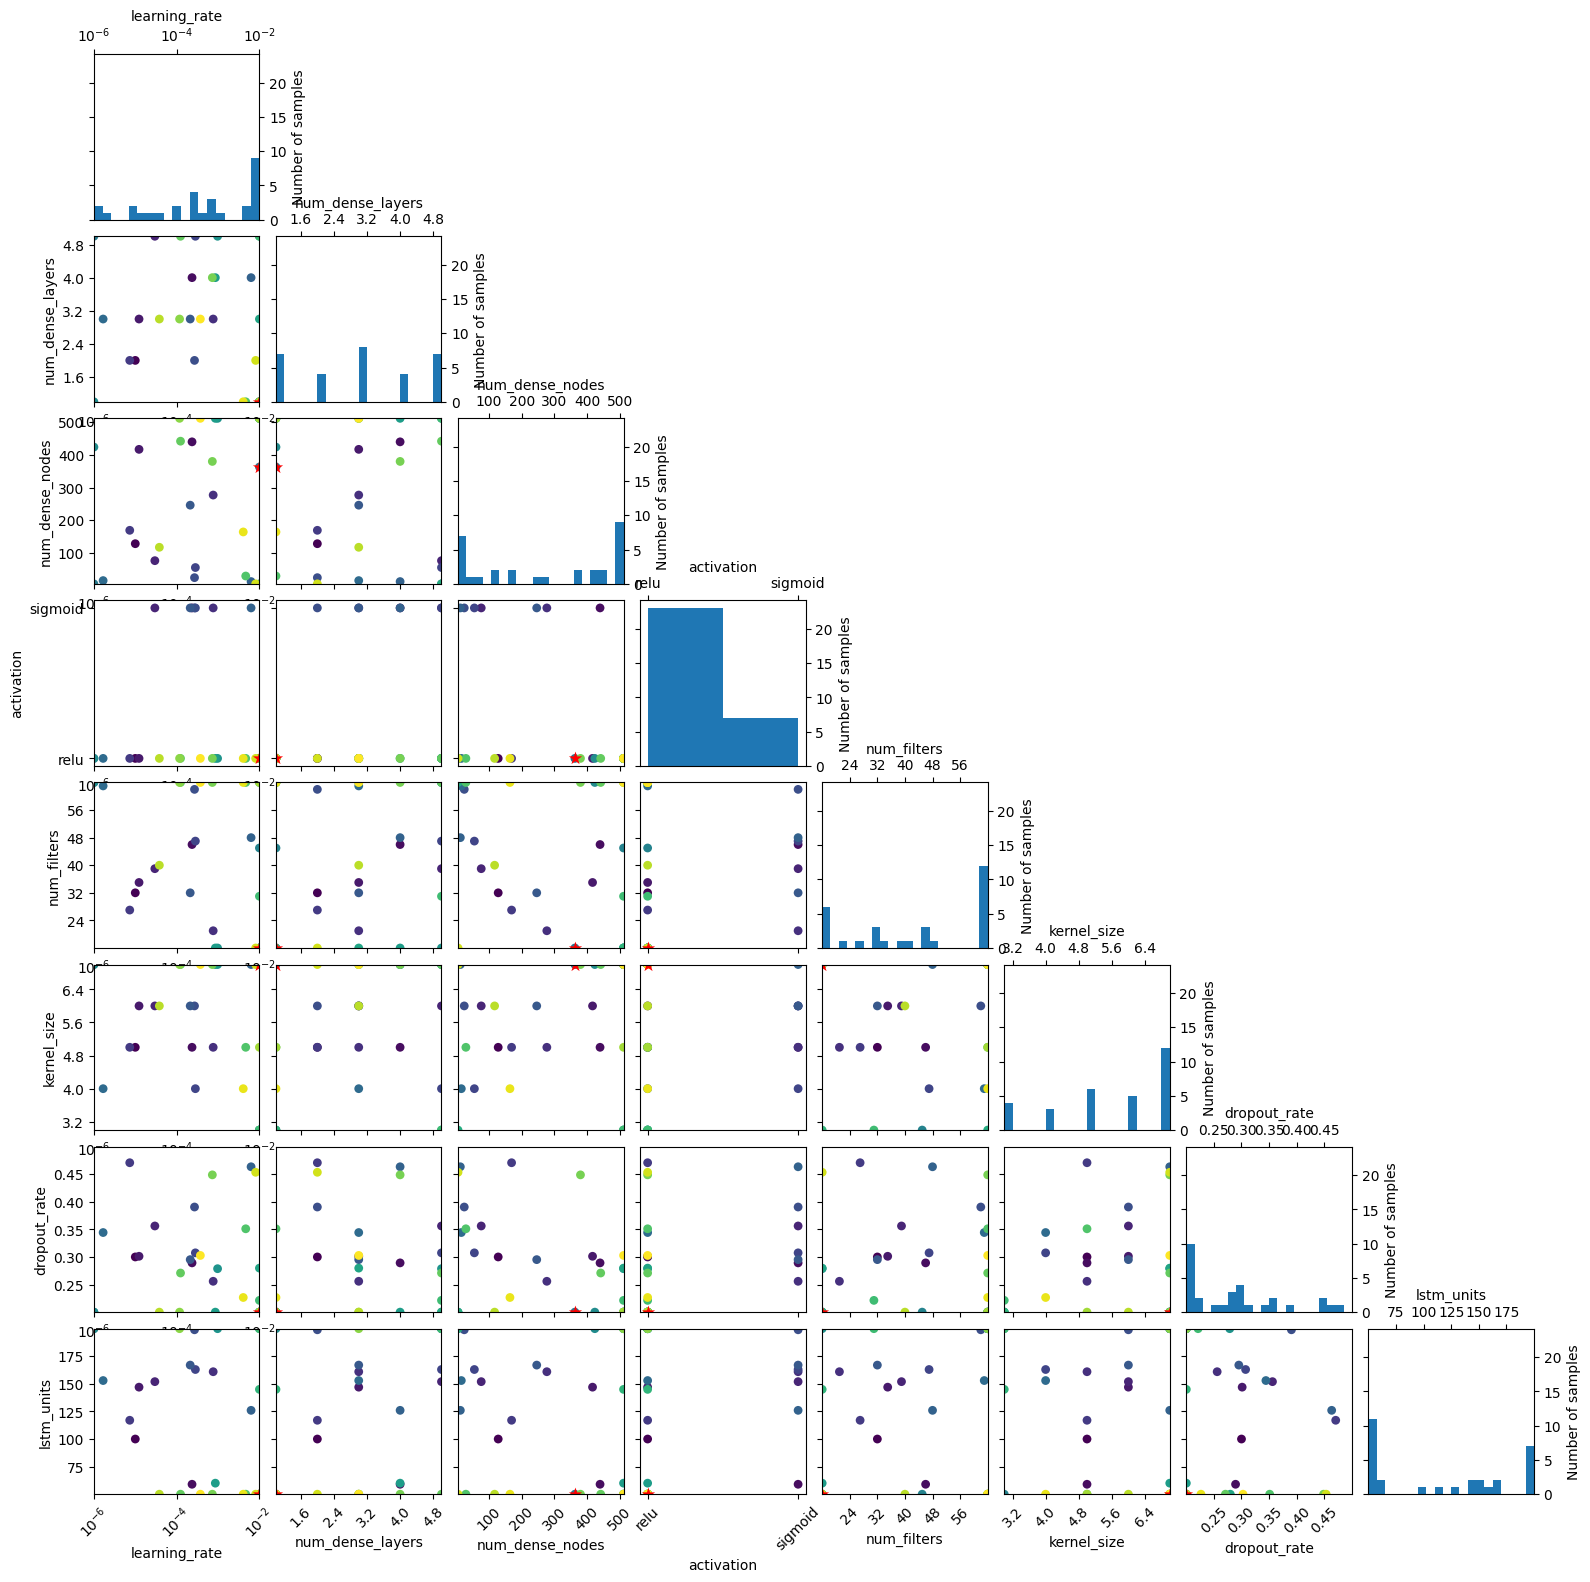

In [132]:
# This plot shows how the parameters were tweaked and where the most of the evaluations were done.
plot_evaluations(result=gp_, plot_dims=dim_names)
plt.show()

In [133]:
model = load_model(path_best_model)

In [134]:
# make predictions in test set

result = model.evaluate(x=X_test,
                        y=y_test)

300/300 [==============================] - 3s 5ms/step - loss: 0.0305 - accuracy: 0.9914


In [135]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.030479956418275833
accuracy 0.9913541674613953


In [137]:
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis = 1)
y_true = np.argmax(y_test, axis = 1)
# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes) 
cm

300/300 [==============================] - 2s 5ms/step


array([[3924,    2,    1,   32,    8],
       [   4, 1364,    0,    3,    1],
       [   3,    0, 1455,    3,    0],
       [  15,    0,    3, 1352,    0],
       [   5,    1,    1,    1, 1422]])

Text(0.5, 34.54715460257994, 'Predicted label')

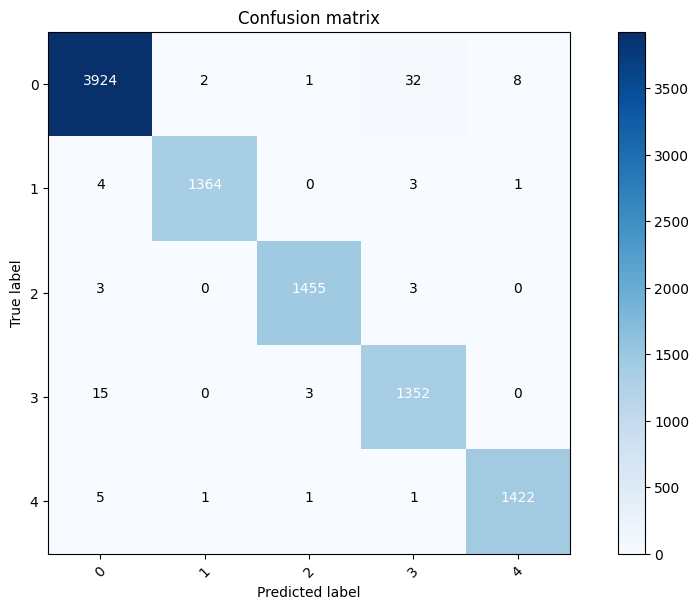

In [139]:
# let's make it more colourful
classes = 5

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(classes)
plt.xticks(tick_marks, range(classes), rotation=45)
plt.yticks(tick_marks, range(classes))

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > 100 else "black",
            )

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')